In [14]:
import cv2
import numpy as np
import imageio.v3 as iio

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

from skimage import metrics

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [15]:
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

SPEED = 0.1

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    # plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    # plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
# clew = initialise_clew(50, image.shape, (40, 30, 2))

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


In [16]:
rng.random()
WE = 1.4
WI = 0.05

In [25]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour

        self.position = np.array([self.r, self.theta, self.dr, self.dgamma, self.width, self.colour])
        self.best_pos = self.position
        self.best_value = 0
        self.velocitiy = np.array([SPEED * (rng.random()-0.5) for _ in range(6)])
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points
    
    def move(self):
        self.position += self.velocitiy
        if self.position[0] < 0:
            self.position[0] = 0
        elif self.position[0] > 100:
            self.position[0] = 75

        if self.position[5] < 0:
            self.position[5] = 1
        elif self.position[5] > 1:
            self.position[5] = 0
        self.r, self.theta, self.dr, self.dgamma, self.width, self.colour = self.position
        
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(int(self.r / 8))))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[1],point[0]] for point in intermediates]
        return(np.array(colours)/255)
    
    # def environment_fitness(self, image):
    #     arr = []
    #     points = int(self.approx_length() / 10) if self.approx_length() / 10 > 3 else 3
    #     intermediates = self.intermediate_points(points)
    #     for point in intermediates:
    #         if (point[0] < 720 and point[1] < 240): 
    #             arr.append(125 - abs(self.colour * 255 - image[int(point[1]), int(point[0])]))
    #         else:
    #             arr.append(0)
    #     return np.average(arr)
    
    def environment_fitness(self, image, points=3):
        arr = []
        steps = np.pi / 16
        intermediates = self.intermediate_points(points)
        for point in intermediates:
            if (point[0] < 720 and point[1] < 240): 
                arr.append(255 - abs(self.colour * 255 - image[int(point[1]), int(point[0])]))
                rads = 0 
                while (rads < 2 * np.pi):
                    x = int(point[0] + 2 * np.cos(rads))
                    y = int(point[1] + 2 * np.sin(rads))
                    if (x < 720 and y < 240):
                        arr.append(255 - abs(self.colour * 255 - image[y, x]))
                        rads += steps
                    else:
                        arr.append(0)
                        rads += steps
            else:
                arr.append(0)
        return np.average(arr)
    
    def fitness(self, image):
        env_fit = self.environment_fitness(image)  
        # print(WE*env_fit)
        # print(WI * self.approx_length())
        return WE * env_fit
        # return env_fit

    # def distance(self, x, y):
    #     return np.sqrt((self.x - x)**2 + (self.y - y)**2)

In [18]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

    def show_image(self, save=None):
        plt.axis('off')
        if save is not None:
            plt.savefig(save)
        plt.show()

In [19]:
def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

def random_worm2 (x, y, imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = x + 5 * rng.random()
    midy = y + 5 * rng.random()
    midx = midx if midx < xlim else xlim
    midy = midy if midy < ylim else ylim
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

229.7009071085512


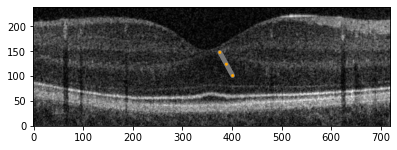

238.0141584960305


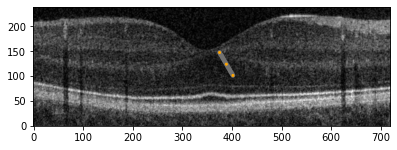

In [20]:
worm = random_worm(image.shape, (40, 30, 3))
print(worm.fitness(image))

drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(3), 2, color="orange")
drawing.show()

worm.move()
print(worm.fitness(image))

drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(3), 2, color="orange")
drawing.show()

In [21]:
class ParticleSwarmOptimisation:
    def __init__(self, x, y, n_worms = 50, w = 0.6, c1 = 1.6, c2 = 1.3):
        self.n_worms = n_worms
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.worms = [random_worm2(x, y, image.shape, (40, 30, 3)) for _ in range(n_worms)]
        self.x = x
        self.y = y 

        self.best_worm_value = 0
        self.best_position = self.worms[0].position

    def run(self):

        count = 0

        while (count < 40):
            self.move_worms()
            self.set_best_worm()
            self.set_worm_individual_best()
            # drawing = Drawing(image)
            # worm = Camo_Worm(150, 150, self.best_position[0], self.best_position[1], self.best_position[2], self.best_position[3], self.best_position[4], self.best_position[5])
            # drawing.add_worms(worm)
            # drawing.add_dots(worm.intermediate_points(int(worm.approx_length() / 10)), 2, color="orange")
            # drawing.show()
            plt.close()
            print(self.best_worm_value)
            count += 1
        print(self.best_worm_value)
        return Camo_Worm(self.x, self.y, self.best_position[0], self.best_position[1], self.best_position[2], self.best_position[3], self.best_position[4], self.best_position[5])

    def move_worms(self):
        for worm in self.worms:
            new_velocity = self.w * worm.velocitiy \
                            + self.c1 * rng.random() * (worm.best_pos - worm.position) \
                            + self.c2 * rng.random() * (self.best_position - worm.position)
            worm.velocitiy = new_velocity
            worm.move()

    def set_best_worm(self):
        for worm in self.worms:
            if worm.fitness(image) > self.best_worm_value:
                self.best_worm_value = worm.fitness(image)
                self.best_position = worm.position

    def set_worm_individual_best(self):
        for worm in self.worms:
            if worm.fitness(image) > worm.best_value:
                worm.best_pos = worm.position
                worm.best_value = worm.fitness(image)

331.49180094632555
341.570224472589
343.39786827673015
343.5647776669301
343.5647776669301
343.5647776669301
343.5647776669301
343.5647776669301
344.46449103419224
344.46449103419224
344.46449103419224
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
345.2132287915485
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
346.41336357766846
336.44941318121204
339.5622055230369
340.41933359089273
340.41933359089273
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341.2327382656123
341

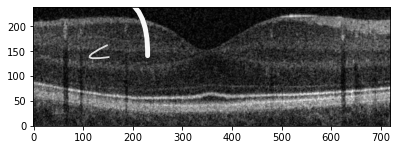

In [30]:
clews = []
pso = ParticleSwarmOptimisation(x=150, y=150)
clews.append(pso.run())
pso = ParticleSwarmOptimisation(x=200, y=200)
clews.append(pso.run())
drawing = Drawing(image)
drawing.add_worms(clews)
drawing.show()
